In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import json
from tqdm import tqdm
from collections import defaultdict
from copy import deepcopy
from numba import njit
from numba.typed import List

from lobio.lob.limit_order import LimitOrder, AMOUNT_TICK, PRICE_TICK
from lobio.lob.order_book import TraderId, Side
from lobio.lob.order_book import OrderBook, OrderBookPrep
from lobio.utils.utils import group_diffs, get_initial_order_book, merge_orders, \
    check_if_sorted, group_historical_trades, find_unseen_dynamic_of_lob, group_orders

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# TRADES

In [7]:
trades_by_diff = []

trades_index = 0
for v in diffs:
    time_to = v[0]
    trades_after_diff = []
    cur_trade = trades.iloc[trades_index]
    while (cur_trade["timestamp"] <= time_to) and (trades_index + 1 < len(trades)):
        limit_order = LimitOrder(
            float(cur_trade["price"]),
            float(cur_trade["amount"]),
            int(cur_trade["side"]),
            TraderId.MARKET,
        )
        trades_after_diff.append((cur_trade["timestamp"], limit_order))
        trades_index += 1
        cur_trade = trades.iloc[trades_index]
    trades_by_diff.append(trades_after_diff)

In [8]:
buy_moves = []
sell_moves = []

for i, cur_trades in enumerate(trades_by_diff):
    cur_buy_prices = []
    cur_sell_prices = []
    for _, trade in cur_trades:
        if trade.side == 0:
            cur_buy_prices.append(trade.base)
        else:
            cur_sell_prices.append(trade.base)
    
    if len(cur_buy_prices):
        buy_moves.append(round(np.max(cur_buy_prices) - np.min(cur_buy_prices), 2))
    else:
        buy_moves.append(0)

    if len(cur_sell_prices):
        sell_moves.append(round(np.max(cur_sell_prices) - np.min(cur_sell_prices), 2))
    else:
        sell_moves.append(0)

In [9]:
np.argmax(buy_moves), np.argmax(sell_moves), np.max(buy_moves), np.max(sell_moves)

(15105, 9081, 1.01, 0.55)

In [10]:
unseen_diffs = []
ts_diffs = []

for i, cur_trades in enumerate(trades_by_diff):
    last_trade_price_buy = 0.0
    last_trade_price_sell = np.inf
    for j, (ts, trade) in enumerate(cur_trades):
        if trade.side == 0:
            if trade.base < last_trade_price_buy:
                unseen_diffs.append((i, ts, trade, j, len(cur_trades)))
                ts_diffs.append((i, ts - cur_trades[j-1][0]))
            last_trade_price_buy = trade.base
        else:
            if trade.base > last_trade_price_sell:
                unseen_diffs.append((i, ts, trade, j, len(cur_trades)))
                ts_diffs.append((i, ts - cur_trades[j-1][0]))
            last_trade_price_sell = trade.base

In [11]:
ts_diffs

[(3929, 1.0),
 (4547, 17.0),
 (5799, 16.0),
 (5799, 4.0),
 (9547, 20.0),
 (9548, 90.0),
 (11751, 1.0),
 (11788, 23.0),
 (13705, 26.0),
 (15105, 7.0)]

In [12]:
unseen_diffs

[(3929, 1708780459903.0, LimitOrder(2957.38, 3.417, 0, 0), 179, 186),
 (4547, 1708780524573.0, LimitOrder(2959.24, 0.1, 0, 0), 97, 98),
 (5799, 1708780654770.0, LimitOrder(2961.92, 0.7143, 1, 0), 55, 65),
 (5799, 1708780654788.0, LimitOrder(2961.99, 0.0037, 1, 0), 60, 65),
 (9547, 1708781044910.0, LimitOrder(2962.2, 0.006, 1, 0), 105, 108),
 (9548, 1708781045028.0, LimitOrder(2961.76, 0.0894, 1, 0), 15, 16),
 (11751, 1708781279999.0, LimitOrder(2962.52, 0.028, 1, 0), 35, 59),
 (11788, 1708781283768.0, LimitOrder(2963.03, 0.0056, 1, 0), 11, 12),
 (13705, 1708781485472.0, LimitOrder(2961.75, 0.0202, 0, 0), 2, 3),
 (15105, 1708781636060.0, LimitOrder(2962.21, 0.0022, 0, 0), 109, 136)]

# END TRADES

In [2]:
diffs_prepared_file = "../data/diffs_prepared.parquet"
init_lob_prepared_file = "../data/init_lob_prepared.npy"
aggtrades_file = "../data/aggtrades_raw.parquet"

# with open(diffs_prepared_file, "rb") as file:
#     diffs = pd.read_parquet(file)
diffs = pl.read_parquet(diffs_prepared_file)
with open(init_lob_prepared_file, "rb") as file:
    init_lob = np.load(file)
# with open(aggtrades_file, "rb") as file:
#     aggtrades_raw = pd.read_parquet(file)
aggtrades_raw = pl.read_parquet(aggtrades_file)

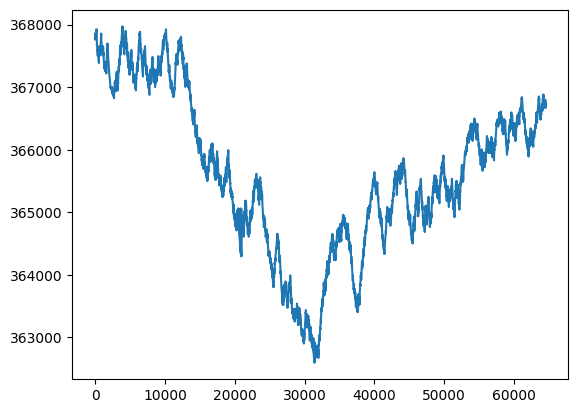

In [3]:
plt.plot(aggtrades_raw['base'])
plt.show()

In [4]:
aggtrades_raw = aggtrades_raw.to_numpy().astype(int)

In [5]:
prev_ts = aggtrades_raw[0][0]
cur_ts_trades = [aggtrades_raw[0]]
for i, trade in enumerate(aggtrades_raw[1:]):
    if trade[0] == prev_ts:
        cur_ts_trades.append(trade)
    else:
        prev_sides = [cur_ts_trades[0][3]]
        for prev_tr in cur_ts_trades[1:]:
            if prev_tr[3] != prev_sides[-1]:
                prev_sides.append(prev_tr[3])
        if len(prev_sides) > 2:
            print(i, cur_ts_trades)
        prev_ts = trade[0]
        cur_ts_trades = [trade]

391 [array([1710532919155,        367506,            43,            -1]), array([1710532919155,        367505,             6,             1]), array([1710532919155,        367504,          1491,             1]), array([1710532919155,        367506,         32194,            -1])]
710 [array([1710532921020,        367639,          1366,             1]), array([1710532921020,        367640,            73,            -1]), array([1710532921020,        367639,         15960,             1]), array([1710532921020,        367638,             6,             1]), array([1710532921020,        367636,           271,             1]), array([1710532921020,        367635,          2000,             1]), array([1710532921020,        367630,           542,             1]), array([1710532921020,        367628,            54,             1]), array([1710532921020,        367623,          3071,             1]), array([1710532921020,        367622,          1789,             1]), array([1710532921020,   

In [6]:
for i, trade in enumerate(aggtrades_raw[1:]):
    if trade[0] == aggtrades_raw[i][0]:
        if trade[3] == aggtrades_raw[i][3]:
            if trade[3] == Side.SELL and trade[1] > aggtrades_raw[i][1]:
                print(i, aggtrades_raw[i], trade, sep='\n')
            elif trade[3] == Side.BUY and trade[1] < aggtrades_raw[i][1]:
                print(i, aggtrades_raw[i], trade, sep='\n')

1416
[1710532931157        367270          5867             1]
[1710532931157        367294            43             1]
1515
[1710532931742        367252          3288             1]
[1710532931742        367268            76             1]
13709
[1710533225499        366778            17             1]
[1710533225499        366786           146             1]
13756
[1710533226150        366724           347             1]
[1710533226150        366738             8             1]
13796
[1710533226327        366667            18             1]
[1710533226327        366678            27             1]
13914
[1710533227298        366580           278             1]
[1710533227298        366582            54             1]
13929
[1710533227321        366560          1103             1]
[1710533227321        366570            27             1]
14050
[1710533227338        366406         12203             1]
[1710533227338        366448            21             1]
14052
[1710533227338      

In [22]:
ob = get_initial_order_book(init_lob)

In [9]:
diffs_grouped = group_diffs(diffs)

In [23]:
for i, diff in enumerate(tqdm(diffs_grouped)):
    if ob.bids[0].base >= ob.asks[0].base:
        print(i)
    ob.apply_historical_update(diff)
    ob.remove_bid_ask_intersection()

  0%|          | 0/23209 [00:00<?, ?it/s]

100%|██████████| 23209/23209 [00:15<00:00, 1516.96it/s]
